In [22]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler,PowerTransformer,RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from apyori import apriori
from itertools import combinations, groupby,chain
from collections import Counter
import ast

%matplotlib inline 

### Project Objective:

1. Customer Segmentation for better understanding of their purchase behavior<br>
2. Stategize marketing plans to improve AOV(Average Order Value) and Revenue<br>
3. Conducting Product association analysis to improve product recommendations<br>

### Methodology:

1. __Loadind The Data__:<br>
 ***
2. __Data Preprocessing__:<br>
2.1 Removing doubtful entries<br>
2.2 Final Data
***
3. __RFM Analysis__:<br>
3.1 Recency<br>
3.2 Frequency<br>
3.3 Monetary<br>
3.4 Creating RFM Table<br>
3.5 Customer Segmentation using RFM Model<br>
***
4. __Customer Segmentation using Kmeans clustering__:<br>
4.1 Data preprocessing<br>
4.2 Selecting Kmeans Clusters<br>
4.3 Kmeans cluster model<br>
4.4 Cluster Analysis<br>
***
5. __Customer Segmentation and Marketing Strategies based on Kmeans Clusters and RFM Score__:<br>
5.1 Based on Kmeans Clustering<br>
5.2 Based on RFM Score<br>
***
6. __Product Association Analysis__:<br>
6.1 Introduction to Support, Confidence & Lift<br>
6.2 Supporting Functions for Apriori Algorithm<br>
6.3 Apriori Algorithm<br>
6.4 Association rule result interpretation<br>
***

## 1.Loading the Data

In [23]:
df = pd.read_csv('data.csv',encoding="ISO-8859-1")

In [24]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 2.Data Preprocessing

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [26]:
### Checking Null Values

In [27]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [28]:
## Customer ID is Important Attribute for customer Segmentation analysis,so removing Null values makes sense.
## We can afford to have null values for Description attribute

In [29]:
df = df[df['CustomerID'].notnull()]
df.drop_duplicates(inplace= True)

In [30]:
## Customer ID should be string

In [31]:
df['CustomerID'] = df['CustomerID'].apply(str)
df['CustomerID'] = df['CustomerID'].apply(lambda x:x.split('.')[0])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

In [32]:
## Checking Country-wise Orders
pd.DataFrame({'Proportion_of_orders':df['Country'].value_counts(normalize = True)})

,Proportion_of_orders
United Kingdom,0.888258
Germany,0.023605
France,0.021103
EIRE,0.018613
Spain,0.006295
Netherlands,0.005904
Belgium,0.005152
Switzerland,0.004674
Portugal,0.003663
Australia,0.003132


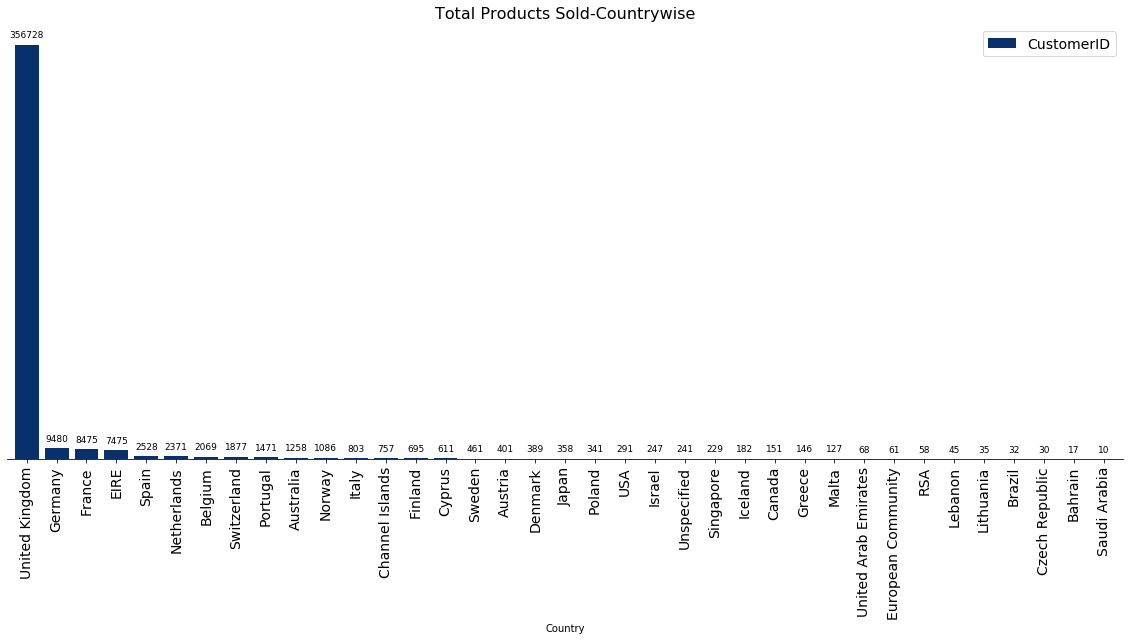

In [33]:
aa = df.groupby('Country').count().sort_values('CustomerID',ascending=False)['CustomerID']
ax = aa.plot(kind='bar', 
            figsize=(20, 8), 
            width=0.8, 
            cmap='Blues_r',
           )
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
ax.set_title("Total Products Sold-Countrywise", fontsize=16)
for p in ax.patches:
    ax.annotate(np.round(p.get_height()), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 9
               )

__88.95% of Total products sold are from United Kingdom. 
We will focus our analysis for UK orders, as customer cluster may vary geographically__

In [34]:
df = df[df['Country']=='United Kingdom']

In [35]:
df.describe()

,Quantity,UnitPrice
count,356728.000000,356728.000000
mean,11.198644,3.268255
std,264.998044,71.162330
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,4.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


__The Quantity column has negative values.lets check__

In [36]:
df[df['Quantity']<0]['InvoiceNo'].nunique()

3208

__Total 3208 invoices  has negative quantity for products. looks like these products has been returned.<br>
If they are returned means they must be bought before that.
lets look into this__

### 2.1 Removing doubtful entries

In [37]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

In [38]:
entry_to_remove = []        # Returned Product which where bought in the same timeframe
doubtfull_entry = []

In [39]:
for index,col in df.iterrows():
    if col['Quantity']>0:      #It goes to next row if quantity is greater than zero
        continue
        
    df_test = df[(df['CustomerID']==col['CustomerID']) &
                (df['StockCode']==col['StockCode']) &
                (df['InvoiceDate'] < col['InvoiceDate'])&
                (df['Quantity']>0)].copy()
    
    #-------------
    # Cancelletion without previous purchase record
    if(df_test.shape[0]==0):
        doubtfull_entry.append(index)
    
    #-------------
    # Cancellation with Previous single purchase record
    elif(df_test.shape[0]==1):
        entry_to_remove.append(index)
        index_order = df_test.index[0]
        
        df_cleaned.loc[index_order,'QuantityCanceled'] = -1*col['Quantity']
        
    #-------------
    
    # Various previous purchase record,we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [40]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

In [41]:
## Removing those entries where returned quantity is greater than quantity bought
df_cleaned = df_cleaned[df_cleaned['QuantityCanceled']<df_cleaned['Quantity']]

In [42]:
## now adjusting Quantity and order for those who returned less item than they bought

In [43]:
df_cleaned['Total_cost'] = (df_cleaned['Quantity']-df_cleaned['QuantityCanceled'])*df_cleaned['UnitPrice']
df_cleaned['Quantity']  = df_cleaned['Quantity'] - df_cleaned['QuantityCanceled']

### 2.2 Final Data

In [44]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Total_cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,0,20.34


In [45]:
df_cleaned.drop('QuantityCanceled',axis=1,inplace=True)

In [46]:
df = df_cleaned.copy()

In [47]:
print('Important Summary')
print('Number of Transactions:  {}'.format(df['InvoiceNo'].nunique()))
print('Number of Product Solds: {}'.format(df['StockCode'].nunique()))
print('Number of Customers:     {}'.format(df['CustomerID'].nunique()))
print('Earliest Transaction:    {}'.format(min(df['InvoiceDate'])))
print('Latest Transaction:      {}'.format(max(df['InvoiceDate'])))

Important Summary
Number of Transactions:  16585
Number of Product Solds: 3641
Number of Customers:     3915
Earliest Transaction:    2010-12-01
Latest Transaction:      2011-12-09


In [48]:
# The Duration is little over a year, which is ideal for metric

## 3. RFM Analysis

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

__RECENCY (R)__: Days since last purchase<br>
__FREQUENCY (F)__: Total number of purchases<br>
__MONETARY VALUE (M)__: Total money perticular customer spent.<br>

### 3.1 Recency

Recency is how many days ago customer did his last purchase at store<br>
Recency Analysis needs a date for reference. For that we will use the latest transaction date

In [49]:
latest = max(df['InvoiceDate'])
print(latest)

2011-12-09


In [50]:
# find Latest Transaction date for each customer
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.34


In [51]:
recency_df = pd.DataFrame({'Latest_Transaction_date':df.groupby('CustomerID').max()['InvoiceDate']}).reset_index()
recency_df.head()

,CustomerID,Latest_Transaction_date
0,12346,2011-01-18
1,12747,2011-12-07
2,12748,2011-12-09
3,12749,2011-12-06
4,12820,2011-12-06


#### Calculating Recency

In [52]:
recency_df['Recency'] = recency_df['Latest_Transaction_date'].apply(lambda x:(latest-x).days)
recency_df.drop('Latest_Transaction_date',axis=1,inplace=True)
recency_df.head()

,CustomerID,Recency
0,12346,325
1,12747,2
2,12748,0
3,12749,3
4,12820,3


### 3.2  Frequency

frequency is total number of times a customer has shopped at store in given duration

In [53]:
frequency_df = pd.DataFrame({'Frequency':df.groupby('CustomerID').nunique()['InvoiceNo']}).reset_index()

In [54]:
frequency_df.head()

,CustomerID,Frequency
0,12346,1
1,12747,11
2,12748,209
3,12749,5
4,12820,4


### 3.3 Monetary

Monetary is total amount of money customer spent in given duration

In [55]:
df['Total_cost'] = df['Quantity'] * df['UnitPrice']

In [56]:
monetary_df = pd.DataFrame({'Monetary':df.groupby('CustomerID').sum()['Total_cost']}).reset_index()
monetary_df.head()

,CustomerID,Monetary
0,12346,77183.60
1,12747,4196.01
2,12748,32124.97
3,12749,3868.20
4,12820,942.34


### 3.4 Creating RFM Table

In [57]:
recency_df.shape,frequency_df.shape,monetary_df.shape

((3915, 2), (3915, 2), (3915, 2))

In [58]:
RFM_df = recency_df.merge(frequency_df)

In [59]:
RFM_df = RFM_df.merge(monetary_df)

In [60]:
RFM_df.shape

(3915, 4)

In [61]:
RFM_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12747,2,11,4196.01
2,12748,0,209,32124.97
3,12749,3,5,3868.20
4,12820,3,4,942.34


In [62]:
RFM_df.set_index('CustomerID',inplace=True)

### 3.5 Customer Segmentation with RFM Model

The simplest way to create customers segments from RFM Model is to use Quartiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

In [63]:
quantile_df = RFM_df.quantile([0.25,0.5,0.75])

In [64]:
quantile_df

,Recency,Frequency,Monetary
0.25,17.0,1.0,292.405
0.50,50.0,2.0,636.240
0.75,142.5,5.0,1546.385


In [65]:
#arguments (x = value,attr = Recency/Frequency/Monetary)

def Recency_score(x,attr):
    
    q = quantile_df
    
    if x <=q[attr][0.25]:
        return 4
    elif x<=q[attr][0.50]:
        return 3
    elif x<=q[attr][0.75]:
        return 2
    else:
        return 1
    
def FreqMon_score(x,attr):
        
    q = quantile_df
    
    if x <=q[attr][0.25]:
        return 1
    elif x<=q[attr][0.50]:
        return 2
    elif x<=q[attr][0.75]:
        return 3
    else:
        return 4
    

In [66]:
RFM_df['R_score'] = RFM_df['Recency'].apply(Recency_score,args=('Recency',))
RFM_df['F_score'] = RFM_df['Frequency'].apply(FreqMon_score,args=('Frequency',))
RFM_df['M_score'] = RFM_df['Monetary'].apply(FreqMon_score,args=('Monetary',))

In [67]:
RFM_df.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score
CustomerID,,,,,,
12346,325,1,77183.60,1,1,4
12747,2,11,4196.01,4,4,4
12748,0,209,32124.97,4,4,4
12749,3,5,3868.20,4,3,4
12820,3,4,942.34,4,3,3


In [68]:
RFM_df['RFM_Score'] = RFM_df['R_score']*100 + RFM_df['F_score']*10 + RFM_df['M_score']*1
RFM_df['RFM_Score'] = RFM_df['RFM_Score'].apply(str)

In [69]:
RFM_df['RFM_Score'].value_counts()

444    421
111    398
112    209
333    187
211    183
      ... 
342      2
314      2
142      1
414      1
441      1
Name: RFM_Score, Length: 61, dtype: int64

### 4. Customer Segmentation using Kmeans Clustering

### 4.1 Data Preprocessing

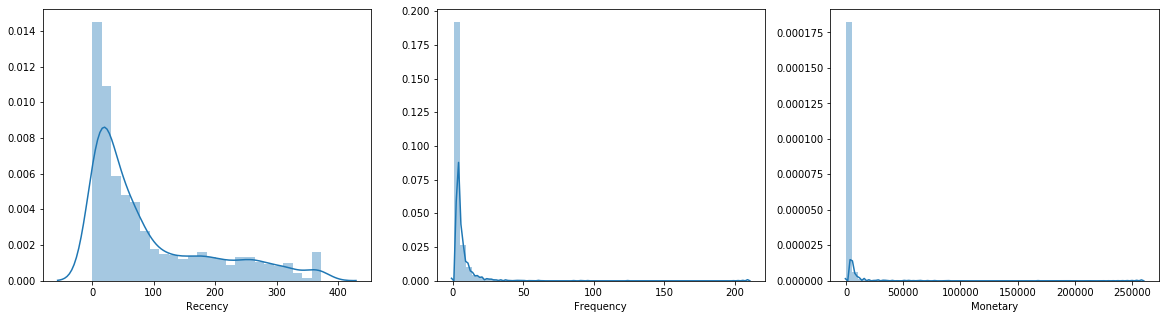

In [70]:
fig,ax = plt.subplots(1,3,figsize = (20,5))
sns.distplot(RFM_df['Recency'],ax=ax[0])
sns.distplot(RFM_df['Frequency'],ax=ax[1])
sns.distplot(RFM_df['Monetary'],ax=ax[2])

In [71]:
## The Data Looks Positively Skewed
print("Skewness of Recency: {}".format(RFM_df['Recency'].skew()))
print("Skewness of Frequency: {}".format(RFM_df['Frequency'].skew()))
print("Skewness of Monetary: {}".format(RFM_df['Monetary'].skew()))

Skewness of Recency: 1.2449479298095047
Skewness of Frequency: 10.79832389848548
Skewness of Monetary: 20.771597563597865


In [72]:
## Skewness value of all attribute is more than 1 for all attribute. So we can say all are positively features

In [73]:
RFM_df['Recency'] = RFM_df['Recency'].apply(lambda x:x+1)
RFM_df['Monetary'] = RFM_df['Monetary'].apply(lambda x:x+0.0000001)

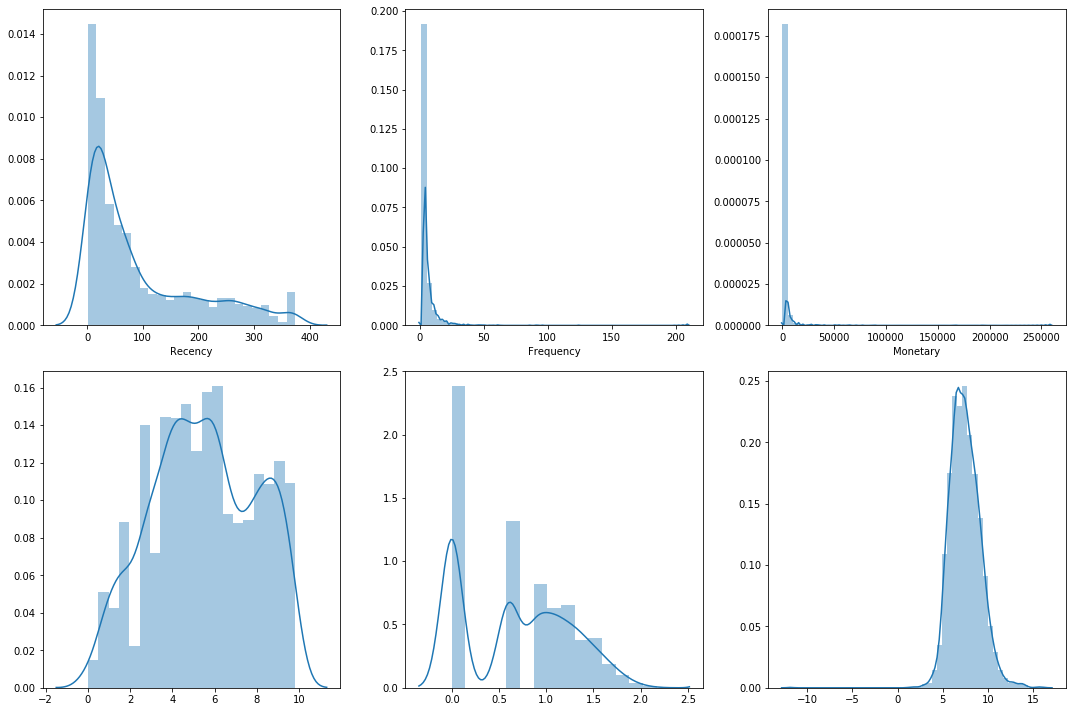

In [74]:
## Lets try Box-cox transformation 
fig,ax = plt.subplots(2,3,figsize = (15,10))
sns.distplot(RFM_df['Recency'],ax=ax[0,0])
sns.distplot(RFM_df['Frequency'],ax=ax[0,1])
sns.distplot(RFM_df['Monetary'],ax=ax[0,2])
sns.distplot(stats.boxcox(RFM_df['Recency'])[0],ax=ax[1,0])
sns.distplot(stats.boxcox(RFM_df['Frequency'])[0],ax=ax[1,1])
sns.distplot(stats.boxcox(RFM_df['Monetary'])[0],ax=ax[1,2])
plt.tight_layout()
plt.show()

In [75]:
#Lets check their Skewness values after Box-cox transformation
print('Skewness for Recency: {}'.format(pd.Series(stats.boxcox(RFM_df['Recency'])[0]).skew()))
print('Skewness for Frequency: {}'.format(pd.Series(stats.boxcox(RFM_df['Frequency'])[0]).skew()))
print('Skewness for Monetary: {}'.format(pd.Series(stats.boxcox(RFM_df['Monetary'])[0]).skew()))

Skewness for Recency: -0.06381684804981501
Skewness for Frequency: 0.1442611902215325
Skewness for Monetary: 0.12824376442157176


In [76]:
# After Box-Cox Transformation all three features dont show any skewness in their distributions.
RFM_transformed = pd.DataFrame()
RFM_transformed['Recency'] = stats.boxcox(RFM_df['Recency'])[0]
RFM_transformed['Frequency'] = stats.boxcox(RFM_df['Frequency'])[0]
RFM_transformed['Monetary'] = stats.boxcox(RFM_df['Monetary'])[0]

#RFM_transformed['Recency'] = RFM_df['Recency']
#RFM_transformed['Frequency'] = RFM_df['Frequency']
#RFM_transformed['Monetary'] = RFM_df['Monetary']



In [77]:
RFM_transformed

,Recency,Frequency,Monetary
0,9.464689,0.000000,14.214625
1,1.199770,1.527353,9.902577
2,0.000000,2.168285,12.863415
3,1.549908,1.178717,9.789190
4,1.549908,1.057828,7.878430
...,...,...,...
3910,9.072094,0.000000,5.775870
3911,8.062254,0.000000,4.801761
3912,2.461914,0.603468,5.748310
3913,1.549908,1.657489,8.913736


In [78]:
scaler = StandardScaler()
RFM_standardized=scaler.fit_transform(RFM_transformed)
RFM_standardized = pd.DataFrame(RFM_standardized,columns= RFM_transformed.columns)
RFM_standardized.head()

,Recency,Frequency,Monetary
0,1.622539,-1.184236,4.039558
1,-1.738027,1.484555,1.448838
2,-2.225860,2.604474,3.227738
3,-1.595658,0.875373,1.380714
4,-1.595658,0.664140,0.232711


In [79]:
RFM_standardized.describe()

,Recency,Frequency,Monetary
count,3.915000e+03,3.915000e+03,3.915000e+03
mean,-3.673520e-16,1.977984e-16,1.996700e-16
std,1.000128e+00,1.000128e+00,1.000128e+00
min,-2.225860e+00,-1.184236e+00,-1.163785e+01
25%,-7.361403e-01,-1.184236e+00,-6.706691e-01
50%,-9.259147e-03,-1.297766e-01,-7.523896e-02
75%,8.414921e-01,8.753728e-01,6.279989e-01
max,1.763468e+00,2.604474e+00,5.211160e+00


### 4.2 Selecting Number of Clusters

In [80]:
## Modelling
# K-Means clustering 

In [81]:
silhouette_scores = []
distances = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,random_state=42)
    kmeans.fit(RFM_standardized)
    if k>=2:
         silhouette_scores.append((k,silhouette_score(RFM_standardized,kmeans.labels_)))
    distances.append((k,kmeans.inertia_))

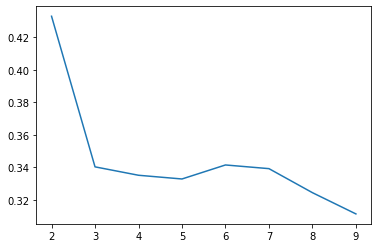

In [82]:
plt.plot(pd.DataFrame(silhouette_scores)[0],pd.DataFrame(silhouette_scores)[1])

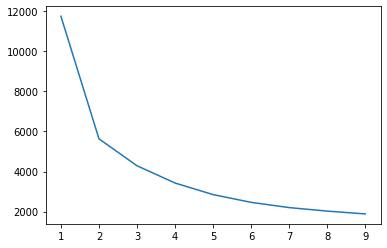

In [83]:
plt.plot(pd.DataFrame(distances)[0],pd.DataFrame(distances)[1])

In [84]:
# From Silhoutte score as well as sum of squared distance(SSE) plots I have selected k = 3.
#because is SSE plot after 3 the plot becomes flat and linear
#

### 4.3 Kmeans Cluster Model

In [85]:
model = KMeans(n_clusters=3)
model.fit(RFM_standardized)
model.labels_.shape

(3915,)

### 4.4 Cluster Analysis

In [86]:
RFM_df['Cluster'] = model.labels_

In [87]:
RFM_df['Cluster'].value_counts()

1    1517
2    1484
0     914
Name: Cluster, dtype: int64

R_score,1,2,3,4
Cluster,,,,
0,7,50,223,634
1,811,406,237,63
2,161,509,507,307


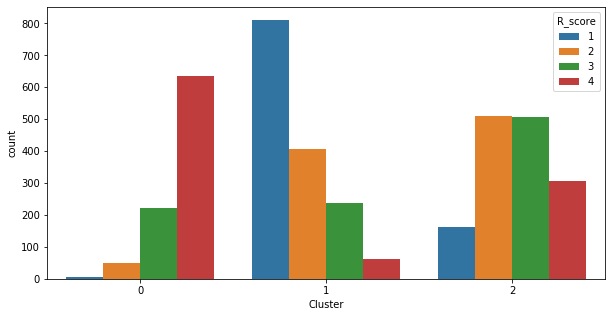

In [88]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'Cluster',hue = 'R_score',data= RFM_df)
RFM_df.groupby(['Cluster','R_score']).count()['Recency'].unstack()

F_score,1,2,3,4
Cluster,,,,
0,1.0,5.0,213.0,695.0
1,1310.0,197.0,10.0,NaN
2,38.0,544.0,808.0,94.0


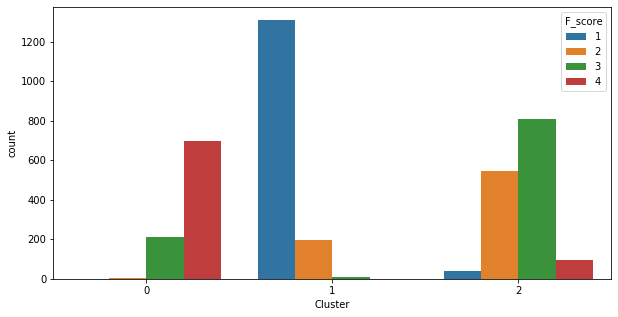

In [89]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'Cluster',hue = 'F_score',data= RFM_df)
RFM_df.groupby(['Cluster','F_score']).count()['Recency'].unstack()

M_score,1,2,3,4
Cluster,,,,
0,NaN,1.0,142.0,771.0
1,862.0,543.0,100.0,12.0
2,117.0,435.0,736.0,196.0


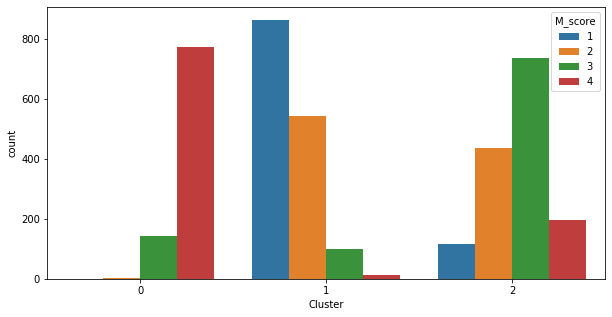

In [90]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'Cluster',hue = 'M_score',data= RFM_df)
RFM_df.groupby(['Cluster','M_score']).count()['Recency'].unstack()

In [91]:
RFM_standardized['ID'] = RFM_df.index
RFM_standardized['Cluster'] = model.labels_
RFM_standardized.head()

,Recency,Frequency,Monetary,ID,Cluster
0,1.622539,-1.184236,4.039558,12346,0
1,-1.738027,1.484555,1.448838,12747,0
2,-2.225860,2.604474,3.227738,12748,0
3,-1.595658,0.875373,1.380714,12749,0
4,-1.595658,0.664140,0.232711,12820,0


In [92]:
#Melt the data

RFM_melt = pd.melt(RFM_standardized.reset_index(),
                  id_vars= ['ID','Cluster'],
                  value_vars = ['Recency','Frequency','Monetary'],
                  var_name = 'Attribute',
                  value_name = 'Value')
RFM_melt.head()

,ID,Cluster,Attribute,Value
0,12346,0,Recency,1.622539
1,12747,0,Recency,-1.738027
2,12748,0,Recency,-2.225860
3,12749,0,Recency,-1.595658
4,12820,0,Recency,-1.595658


,Recency,Frequency,Monetary
,mean,mean,mean
Cluster,,,
0,-1.020830,1.261698,1.253761
1,0.732988,-1.037111,-0.819476
2,-0.120555,0.283090,0.065504


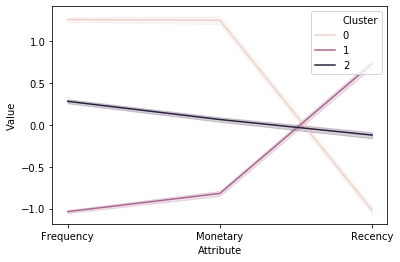

In [93]:
sns.lineplot('Attribute','Value',hue='Cluster',data = RFM_melt)
RFM_standardized.groupby('Cluster').agg({'Recency':[np.mean],
                              'Frequency':[np.mean],
                              'Monetary':[np.mean]})

## 5. Customer Segmentation and Marketing Strategies based on Kmeans Clusters and RFM Score

### 5.1 Based on Kmeans Clustering
__Cluster 2 is Frequent,Spend more and they have bought product recently, it is cluster of loyal customers__<br>
__cluster 1 is less frequent, spends less and havent bought a product recently, it can be called cluster of churned__<br>
__Cluster 0 customer are Average Spenders__<br>


### 5.2 Based on RFM Score

### 1. RFM Score: 444 
__Best Customers__<br>
__Who are they__:Highly engaged customers who have bought the most recent, the most often, and generated the most revenue.<br>
__Marketing Strategies__: These customers have already shown willingness to spend more, so no need to use discount pricing. Focus on Loyalty Programs and New Product Introductions.We can focus on Product Recommendations based on purchase history to give value added offers<br>
### 2. RFM Score: X4X
__Loyal Customers__<br>
__Who are they__:Customers who buy most often.<br>
__Marketing Strategies:__ Loyalty programs like Free Shipping like Amazon Prime,small cashback offers on every purchase keeps them motivated to visit and spend often<br>
### 3. RFM Score: X13,X14
__faithful and Promising Customers__<br>
__Who are they__:Customer who visits often, but do not spend a lot.<br>
__Marketing Strategies__: We already have succeded in creating loyalty,our target is to make them spend more. We can achieve this by adding incentives to spending threshold. That threshold should be somewhat more than our Average Order Value(AOV) Target<br>
### 4. RFM Score: XX4
__Highest Paying Customers__<br>
__Who are they__: Customer who have generated most revenue<br>
__Marketing Strategies__: They already trust and like the your product. Consider premium offers(discount on buying complimentary products/Product bundling), better loyalty program offers<br>
### 5. RFM Score: 41X
__Newest Customers__<br>
__Who are they__:First time buyers<br>
__Marketing Strategies__:Triggered welcome emails like discount on first purchase or free delivery, Referral program discount to encourage them to promote your site. 

## 6. Product Association Analysis

In [94]:
df1 = pd.read_csv('data.csv',encoding="ISO-8859-1")

As we are concentrating on United Kingdom region, We will again filter UK orders.
We are not concerned about orders which where returned later, as we want to focus on association of products which are bought together.We will just remove returned orders.

In [95]:
df1 = df1[(df1['Quantity']>0) & (df1['Country']=='United Kingdom')]

In [96]:
d=df1[['InvoiceNo','StockCode']].drop_duplicates()

In [97]:
# Converting dataframe with Invoice_id as index and products 
dd = d.set_index('InvoiceNo')['StockCode'].rename('item_id')
display(dd.head(10))
type(dd)

InvoiceNo
536365    85123A
536365     71053
536365    84406B
536365    84029G
536365    84029E
536365     22752
536365     21730
536366     22633
536366     22632
536367     84879
Name: item_id, dtype: object

pandas.core.series.Series

### 6.1 Introduction to Support, Confidence & Lift

__Support__: This is the percentage of orders that contains the indivisual Product<br><br>
_ _ _ _ _ _ _  Support(A)= (Number of order having A)/Total Orders
<br><br>
__Confidence__:Given two items, A and B, confidence measures the percentage of times that item B is purchased, given that item A was purchased.<br><br>
_ _ _ _ _ _ _  confidence{A->B} = support{A,B} / support{A} 
<br><br>
__Lift__:Given two items, A and B, lift indicates whether there is a relationship between A and B, or whether the two items are occuring together in the same orders simply by chance (ie: at random).<br><br>
_ _ _ _ _ _ _  lift{A,B} = lift{B,A} = support{A,B} / (support{A} * support{B})<br><br>

### 6.2 Supporting Functions for Apriori Algorithm

In [106]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().values
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))

# Returns frequency and support associated with item pairs
def combination_count(order_item,qualifying_orders):
    
        a = pd.DataFrame(order_item.reset_index().groupby('InvoiceNo')['item_id'].apply(list).reset_index())
        a['Comb'] = a['item_id'].apply(lambda x:[sorted(i) for i in combinations(x,2)])
        Common_list = list(chain(*a['Comb']))
        Common_list = [str(i) for i in Common_list]
        count_dict = Counter(Common_list)
        pair_df = pd.DataFrame({'a':list(count_dict.keys()),
             'freqAB':list(count_dict.values())})
        pair_df['aa'] = pair_df['a'].apply(ast.literal_eval)
        pair_df['item_A'] = pair_df['aa'].apply(lambda x:x[0])
        pair_df['item_B'] = pair_df['aa'].apply(lambda x:x[1])
        pair_df['supportAB'] = pair_df['freqAB'] / len(qualifying_orders) * 100
        return pair_df[['item_A','item_B','freqAB','supportAB']]



# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]



### 5.3 Apriori Algorithm

In [107]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100

    
    # Get item pairs generator
    #item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    #item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    #item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    


    # Filter from item_pairs those below min support
    item_pairs              = combination_count(order_item,qualifying_orders)
    print("Item pairs: {:31d}".format(len(item_pairs)))
    
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    #item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [125]:
%%time
rules = association_rules(dd, 0.05)

Starting order_item:                 475953
Items with support >= 0.05:            3173
Remaining order_item:                472834
Remaining orders with 2+ items:       16516
Remaining order_item:                470743
Item pairs:                         3366478
Item pairs with support >= 0.05:     917893

CPU times: user 1min 5s, sys: 2.8 s, total: 1min 8s
Wall time: 1min 7s


In [126]:
rules.head(20)

,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
410376,37489A,37489B,11,0.066602,14,0.084766,12,0.072657,0.785714,0.916667,10.814048
410282,37489A,37489D,14,0.084766,14,0.084766,16,0.096876,1.000000,0.875000,10.322500
410270,37489B,37489D,11,0.066602,12,0.072657,16,0.096876,0.916667,0.687500,9.462292
445098,84531A,84531B,22,0.133204,26,0.157423,22,0.133204,0.846154,1.000000,6.352308
696575,90129B,90129C,12,0.072657,20,0.121095,16,0.096876,0.600000,0.750000,6.193500
412373,20734,20960,9,0.054493,26,0.157423,10,0.060547,0.346154,0.900000,5.717077
3209535,23429,23430,9,0.054493,19,0.115040,14,0.084766,0.473684,0.642857,5.588120
441778,51020A,51020B,9,0.054493,18,0.108985,15,0.090821,0.500000,0.600000,5.505333
696576,90129B,90129E,9,0.054493,20,0.121095,14,0.084766,0.450000,0.642857,5.308714
412650,20960,47559b,9,0.054493,10,0.060547,28,0.169533,0.900000,0.321429,5.308714


In [146]:
stockCodes = df1[df1['Description'].notnull()][['StockCode','Description']].drop_duplicates()

In [148]:
stockcode_dict = dict(zip(stockCodes['StockCode'],stockCodes['Description'] ))

In [172]:
rules['item_A'] = rules['item_A'].apply(lambda x:stockcode_dict[x] if x in stockcode_dict.keys() else x)
rules['item_B'] = rules['item_B'].apply(lambda x:stockcode_dict[x] if x in stockcode_dict.keys() else x)

In [174]:
rules.head(20)

,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
410376,YELLOW/PINK FLOWER DESIGN BIG MUG,BLUE/YELLOW FLOWER DESIGN BIG MUG,11,0.066602,14,0.084766,12,0.072657,0.785714,0.916667,10.814048
410282,YELLOW/PINK FLOWER DESIGN BIG MUG,PINK/GREEN FLOWER DESIGN BIG MUG,14,0.084766,14,0.084766,16,0.096876,1.000000,0.875000,10.322500
410270,BLUE/YELLOW FLOWER DESIGN BIG MUG,PINK/GREEN FLOWER DESIGN BIG MUG,11,0.066602,12,0.072657,16,0.096876,0.916667,0.687500,9.462292
445098,returned,returned,22,0.133204,26,0.157423,22,0.133204,0.846154,1.000000,6.352308
696575,TURQUOISE GLASS TASSLE BAG CHARM,GREEN GLASS TASSLE BAG CHARM,12,0.072657,20,0.121095,16,0.096876,0.600000,0.750000,6.193500
412373,SILVER MINI TAPE MEASURE,WATERMELON BATH SPONGE,9,0.054493,26,0.157423,10,0.060547,0.346154,0.900000,5.717077
3209535,RED RETRO KITCHEN WALL CLOCK,BLUE RETRO KITCHEN WALL CLOCK,9,0.054493,19,0.115040,14,0.084766,0.473684,0.642857,5.588120
441778,adjustment,STRIPY DESIGN SHOWER CAP,9,0.054493,18,0.108985,15,0.090821,0.500000,0.600000,5.505333
696576,TURQUOISE GLASS TASSLE BAG CHARM,PURPLE GLASS TASSLE BAG CHARM,9,0.054493,20,0.121095,14,0.084766,0.450000,0.642857,5.308714
412650,WATERMELON BATH SPONGE,TEA TIME OVEN GLOVE,9,0.054493,10,0.060547,28,0.169533,0.900000,0.321429,5.308714


## 5.4 Result Interpretation

-As We can see, similar product have higher association. Customers have shown tendency to buy similar kind of product together.<br>
***
-Like the different color variant of 'Flower design Big Mug', Customer have shown tendency to buy them together, as it make sense as people like to have set of mugs of different colors<br>
***
-As mentioned, one common application of association rules mining is in the domain of recommender systems. Once item pairs have been identified as having positive relationship, recommendations can be made to customers in order to increase sales<br>